# PyMC Gaussian Process Example

## 1. 라이브러리 임포트

In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

## 2. 비선형 데이터 생성

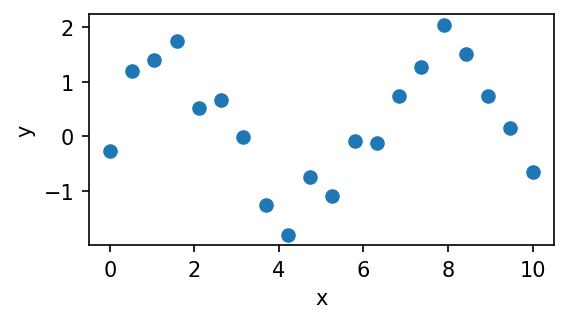

In [2]:
def true_func(x):
    return np.sin(x) * 1.5

X = np.linspace(0, 10, 20)[:, np.newaxis]  # 20개의 훈련 데이터 포인트
y = true_func(X).ravel() + np.random.normal(0, 0.4, 20) # 실제 함수값에 노이즈 추가


fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
ax.plot(X.ravel(), y, 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

## 3. Gaussian Process 모델 적용


Gaussian process (GP)는 함수값들이 multivariate Gaussian 분포를 따르는 함수의 분포입니다.  
즉 GP는 확률 분포이며 샘플링되는 랜덤 변수는 함수이고 그 함수로 함수 값들을 계산하면 그 계산된 값들은  
multivariate Gaussian 분포를 따릅니다.  

Gaussian Process (GP)를 PyMC에서 사용한다는 것은 함수의 형태의 prior로 GP를 사용하는 것입니다.

In [13]:
with pm.Model() as gp_model:
    # --- 커널 하이퍼파라미터에 대한 사전분포(Priors) 설정 ---
    # 길이척도(lengthscale, ℓ): 함수가 얼마나 부드러운지를 제어합니다.
    # Gamma 분포를 사용해 양수 값을 가지도록 합니다.
    lengthscale = pm.Gamma("ls", alpha=2, beta=0.5)

    # 출력 스케일(output-scale, eta): 함수의 평균적인 변동폭을 제어합니다.
    # HalfCauchy 분포는 양수 값을 가지며, 가끔 큰 값이 나올 수 있도록 유연성을 줍니다.
    eta = pm.HalfCauchy("eta", beta=3)

    # --- 커널(공분산 함수) 정의 ---
    # ExpQuad(Squared Exponential) 커널을 사용합니다. 가장 일반적인 선택입니다.
    # 위에서 정의한 하이퍼파라미터(확률 변수)를 커널에 전달합니다.
    # 주어진 데이터의 차원이 1차원이기 때문에 input_dim=1을 사용합니다.
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=lengthscale)

    # --- GP 사전분포(Prior) 정의 ---
    # pm.gp.Latent를 사용해 잠재(Latent) GP를 정의합니다.
    # 이 GP는 우리가 추정하고자 하는 실제 함수 f(x)에 대한 사전 믿음입니다.
    # Gaussian process에서 평균함수는 일반적으로 0으로 고정되어 사용되며 따라서 이 라인에서도
    # 암묵적으로 사용되지 않았습니다.
    gp = pm.gp.Latent(cov_func=cov_func)

    # 모델이 학습할 데이터 X에 대해 GP 사전분포로부터 함수 f를 생성합니다.
    # 이 prior를 지정하기 전까지는 gp는 함수를 랜덤 변수로 가지는 분포이지만 데이터 포인트 X를 
    # 지정하면 해당 함수의 X에서의 값들을 샘플링하여 얻을 수 있게 됩니다.
    # 데이터를 보기전의 함수 값에 대한 사전 분포 P(f | X, ls, eta)를 나타냅니다.
    f = gp.prior("f", X=X)

    # --- 가능도(Likelihood) 정의 ---
    # 관측 노이즈(sigma)에 대한 사전분포를 설정합니다.
    sigma = pm.HalfCauchy("sigma", beta=3)

    # 관측된 데이터 y는 잠재 함수 f에 정규분포 노이즈(sigma)가 더해진 결과라고 가정합니다.
    # 이것이 데이터와 GP 모델을 연결하는 핵심 부분입니다.
    # 이 부분이 가능도 P(y | f, sigma)를 정의하는 부분입니다.
    y_obs = pm.Normal("y_obs", mu=f, sigma=sigma, observed=y)

### TODO: 설명 작성 예정

$$
P(f, l, \eta, \sigma | y, X) = \frac{P(y, X | f, l, \eta, \sigma) \  P(f, l, \eta, \sigma)}{P(y, X)}
$$

$$
P(f, l, \eta, \sigma | y, X) \propto P(y, X | f, l, \eta, \sigma) \  P(f, l, \eta, \sigma)
$$



---

$$
P(y, X | f, l, \eta, \sigma) = P(y | X, f, l, \eta, \sigma) \ P(X | f, l, \eta, \sigma)
$$

$$
P(y | f, \sigma)  \leftarrow P(y | X, f, l, \eta, \sigma) 
$$

---


$$
P(X | f, l, \eta, \sigma) \ P(f, l, \eta, \sigma) = P(X, f, l, \eta, \sigma)
$$

$$
P(X, f, l, \eta, \sigma) = P(f | X, l, \eta, \sigma)  \ P(X, l, \eta, \sigma)
$$

$$
P(X, f, l, \eta, \sigma) = P(f | X, l, \eta, \sigma)  \ P(X) P(l) P(\eta) P(\sigma)
$$

$$
P(f | X, l, \eta) \leftarrow P(f | X, l, \eta, \sigma)
$$


---

$$
P(f, l, \eta, \sigma | y, X) \propto P(y | f, \sigma) \ P(f | X, l, \eta) \ P(l) P(\eta) P(\sigma)
$$


## 4. Sampling

In [4]:
with gp_model:
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=1)

Initializing NUTS using jitter+adapt_diag...
/home/xlsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [ls, eta, f_rotated_, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## 5. Inference

In [5]:
Xnew = np.linspace(-5, 15, 50)[:, np.newaxis]
with gp_model:
    # 새로운 포인트에서의 함수 값에 대한 사후 분포 계산을 위해 새로운 조건부 분포를 정의합니다.
    f_pred = gp.conditional("f_pred", Xnew=Xnew)

In [6]:
with gp_model:
    # 계산된 trace의 sample중 1/10 비율만 사용하여 조건부 분포 계산.
    samples = pm.sample_posterior_predictive(
        trace.posterior.sel(draw=slice(None, None,10)), var_names=["y_obs","f_pred"]
    )

Sampling: [f_pred, y_obs]


Output()

## 6. Simple visualization

In [7]:
samples

Inference data with groups:
	> posterior_predictive
	> observed_data

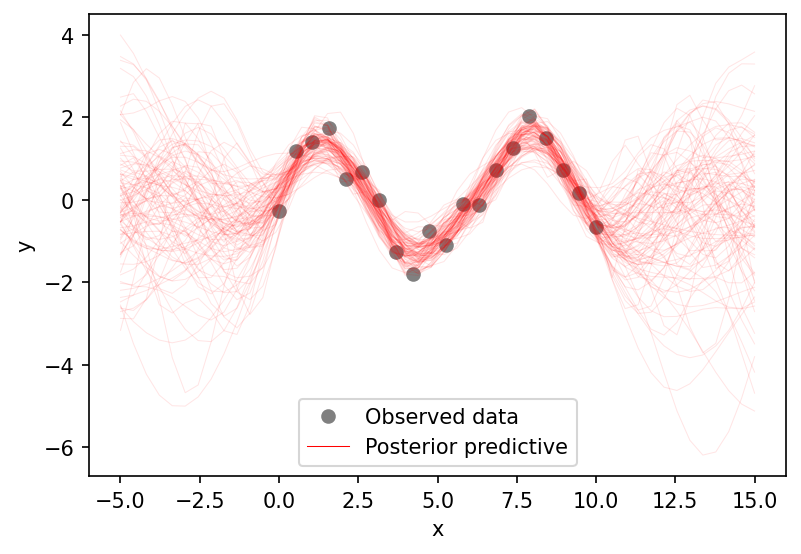

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.plot(X.ravel(), y, 'o', c="gray", label="Observed data")
for i in range(100):
    ax.plot(
        Xnew.ravel(),
        samples.posterior_predictive["f_pred"].stack(sample=("chain", "draw")).isel(sample=i),
        'r',
        lw=0.5,
        alpha=0.1,
    )
ax.plot([], [], 'r', lw=0.5, label="Posterior predictive")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

## 7. 사후 분포 시각화

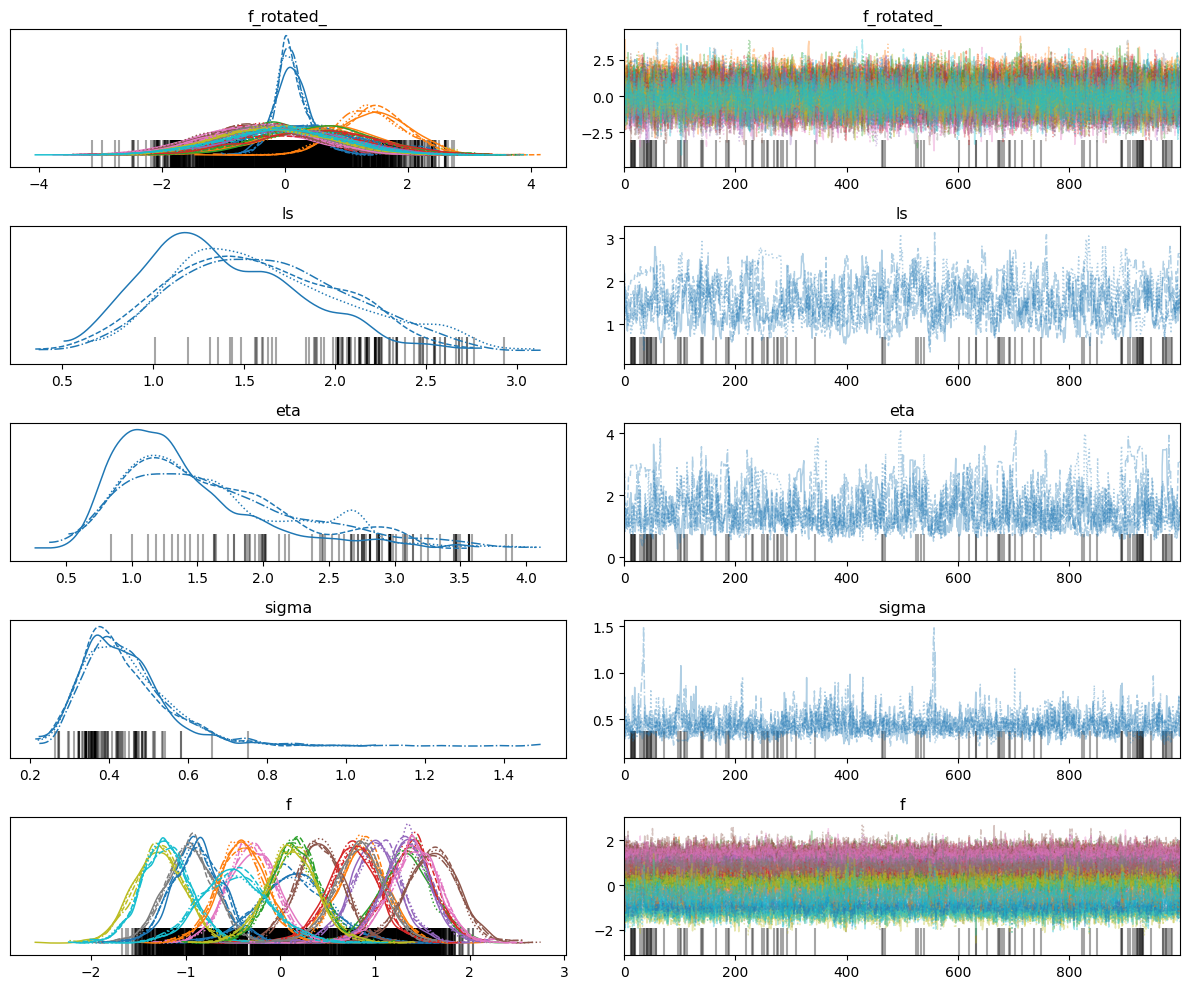

In [9]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()